# Instructions

For this homework, your task is to build an HMM model for annotating S. cerevisiae. Please read through the instructions before you start, to best plan your work.

The work is split up in four sections:

0. Setting up your directories and getting your data 
1. getting baseline results with the HMM-based tool Augustus (code provided)
2. reading a little reference material on HMM gene prediction
3. Going through a toy example that will show you how to:
    * Initiate an HMM model in the R package HMM
    * Use the defined helper functions to extract data sets and  
    * Train a model on data 
    * compare a trained model with base line results from augustus
4. building and training your own HMM

**To complete this homework you need to:**

    1. Initiate your own HMM model (DO NOT USE THE SIMPLE 2 STATE EXAMPLE!!!)
        * Explain the architecture of your model states emmissions etc.
        * Explain what initial parameters you chose and why.
        * Explain if you use any of the references provided or you found your own.
        * Explain if you did test different model architectures or different initial parameters (Not a requirement that you do)
    2. Train your model on data
        * Explain what data you used as training data and why (what chromosomes)
        * Explain what training algorithm you used, did you test both?
        * Explain how many training iterations did you use and why that number.
    3. Evaluate your model with augustus results as shown in the example code.
        * Explain what data you used as testing data (should not be the same as training data).
        * Show at least three histograms with the augustus results initial model and trained model
        * Discuss shortly the evaluation, did your model improve with training, did you get close to augustus?
    4. Given unlimited resorces in both compute and time would you have liked test something more? (just a few sentences)
    
You can work in this notebook and put in your own code. The answers you can type in at the very bottom or in a separate .txt file named Answers-HW4 The histograms can still be in the notebook just specify what line they are generated at. 

This homework together with the project is meant for you to feel a little of how it is like to work as a bioinformatician. Thus, for this homework feel free to experiment and change things if you think there is a better way to do things another way. Just specify what you changed and why. There is of course obvious ways to improve validation and also the annotation of the genes with different patterns. **Most importantly this is meant to be fun!**  

# 0. Setting up your directory
Start by making a HW4 directory. In your HW4 directory you will create a results directory and you will create a data directory. In your data directory you'll place a copy of the file S288C_reference_sequence_R64-2-1_20150113.fsa that we used in the Unix HW. This notebook should be placed in the HW4 directory. After that we should be god to go.  


# 1. Baseline Results
The Augustus base line annotated can be found at /cephyr/NOBACKUP/groups/bbt045_2024/data/ref_annot_augustus.aa. Don't run the augustus commands just proceed to the next step.

# 2. Literature

Read at least the 2 references below (a few pages), to recap the concepts and to maybe get a model as your starting point.
Please very briefly describe your chosen model. Why did you or the authors chose the sates you did? Did the authors mention why they chose the probabilities they did? If you created your own model, how did you decide the probabilities?

References:

- Quick recap of gene annotation with HMMs, along with a simple example model [What is a hidden Markov model?](https://www.nature.com/articles/nbt1004-1315)

- Some lecture slides from the University of Waterloo (pages 1-14 cover models like we've discussed). You could use the model on page 9 as a starting point https://www.math.uwaterloo.ca/~aghodsib/courses/w05stat440/w05stat440-notes/feb27.pdf

- Yet another article describing a number of HMM classes for sequence analysis The model in 2.2. (Fig. 1) could also be a starting point https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2766791/


# 3. The basic (2-state) model 

We'll be playing with simple HMMs using the HMM package, the documentation can be found here [HMM](https://cran.r-project.org/web/packages/HMM/HMM.pdf).

# Imports

In [1]:
# System
import time

# Biology
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Seq import translate
from Bio import SeqIO
#from Bio.Alphabet import IUPAC

# ML, ALG, and NLP 
import re
from hmmlearn import hmm
import numpy as np

# Plotting
import matplotlib.pyplot as plt

### Defining some helper functions
You will use these functions when you set up your own experiments. 

1. `preparing_observations(set, indices)` helps you prepare your data sets 
    * set: expects a DNAStringSet (your loaded reference genome)
    * indices: expect indices of which chromosomes to load (1-17)
    * returns: list of observations
2. `get_gene_start_and_stop_from_annotation(annotation_list, pattern)` helps you get the indices of annotated genes
    * annotation_list: expects annotated observations as a list.
    * pattern: expects regex string (use default 'C+' to get all starts and stops of stretches of C)
    * returns: list of start and stop indices for annotated genes (as pattern describes)
3. `convert_to_proteins(indices, string)` helps you to translate annotated genes to proteins
    * indices: expect output from get_gene_start_stop (first half of list start indices second half stop indices)
    * string: expects DNAString to be translated
    * returns: list of proteins 

In [2]:


def get_gene_start_and_stop_from_annotation(annotation_list, pattern):
    # Function that returns indices of all matches to the pattern
    annotation_string = convert_list_to_string(annotation_list)
    list_of_indices = [match.span() for match in re.finditer(pattern, annotation_string)]
    return list_of_indices

def convert_list_to_string(lst):
    # Helper function that converts lists of individual letters into DNA strings
    return ''.join(lst)

def convert_string_to_list(string):
    # Helper function that converts DNA strings into lists of individual letters
    return list(string)

def convert_to_protein(start, stop, string=""):
    # Convert a DNA string to an AA sequence between the start and stop indices

    dna_seq = Seq(string[start:stop])#, IUPAC.unambiguous_dna)
    return str(dna_seq.translate())

def convert_to_proteins(indices, string):
    # Function that converts the DNA string into proteins where the indices indicate the coding regions
    #n_indices = len(indices) // 2
    indices = np.array(indices)
    start = indices[:, 0]
    stop  = indices[:, 1]
    proteins = [convert_to_protein(i_start, i_stop, string) for i_start, i_stop in zip(start, stop)]
    return proteins

def preparing_observations(seq_set, indices):
    # Prepare data by concatenating all the DNA strings specified by indices
    observations = ''.join([convert_list_to_string(seq_set[i]) for i in indices])
    return observations

def check_for_stop_codon(list_proteins):
    n_stop_codon = 0
    for prot in list_proteins:
        n_stop_codon += prot.count('*')
    return n_stop_codon

# Define function to extract sequence from reference genome set
def extract_sequence(genome_set, chromosome_indices):
    sequences = []
    for index in chromosome_indices:
        sequences.append(str(genome_set[index - 1].seq))
    return sequences


### Model DEFINES

# Define the hidden states of your HMM model
states = ["C", "N"] # Coding: C; None coding: N

# Conversion dictionary states (char to int)
id2region = dict(zip(range(len(states)), states))

vocabulary = ["A", "C", "G", "T"]
# Convert "sentences" to numbers:
vocab2id = dict(zip(vocabulary, range(len(vocabulary))))
id2vocab = {value: key for key, value in vocab2id.items()}


### Prepare Data

We start by loading the reference proteins precomputed by Augustis.

To train our HMM model the HMM module expects the observations to be in a sequence form, we can do this by using the helper function `preparing_observations(set, indices)` and give it the arguments set and indices. Set is the DNAstring set (reference genome) and indices is a vector specifying which chromosomes to load.

When training a model it is **important to validate your improved model on data that the model has not yet seen**. Thus we will prepare **two** data sets one for **training** and one for **testing**. We do this separation by choosing different chromosomes for the two different sets. in the code below we have chosen chromosome 1-2 for the training set and chromosome 3-4 for the test set.

In [3]:
# Load agustus reference
reference_agustus_set = list(SeqIO.parse("data/ref_annot_augustus.aa", "fasta"))
proteins_agustus = extract_sequence(reference_agustus_set, [i for i in  range(len(reference_agustus_set))])


# Load reference genome
reference_genome_set = list(SeqIO.parse("data/S288C_reference_sequence_R64-4-1_20230830.fsa", "fasta"))


# Preparing training set using chromosome 1-2
training_observations = extract_sequence(reference_genome_set, [1, 2])

# Preparing test set using chromosomes 3-4
test_observations = extract_sequence(reference_genome_set, [3, 4])
test_observations_string = "".join(test_observations)

X = []
for chromosome in training_observations:
    row = []
    for char in chromosome:
        row.append([vocab2id[char]])
    X.append(row)
    
X_training = np.concatenate(X)  
lengths_training = [len(x) for x in X]

X = []
for chromosome in test_observations:
    row = []
    for char in chromosome:
        row.append([vocab2id[char]])
    X.append(row)
    
X_test = np.concatenate(X)  
lengths_test = [len(x) for x in X]

### Initiate HMM model

Now it's time to initiate our model, we can do that with the function `hmm.CategoricalHMM` which is part of the HMM module.
We need to specify starting values for the start/transition/emission probabilities as well as the state/emission symbols. 
Below is the same basic model we've seen in the lecture and exercise, provided to show how to use the package.
Skim through the short hmm tutorial to fix some concepts if the code/comments below are confusing.

In [4]:
# Model Parameters
start_probs = np.array([0.3, 0.7])
emission_probs = np.array([[0.3, 0.1], 
                           [0.3, 0.1],
                           [0.2, 0.4],
                           [0.2, 0.4]]).T
trans_mat = np.array([[0.995, 0.005],  
                      [0.01, 0.99]])


# Initiating a simple HMM model
gene_annot_model = hmm.CategoricalHMM(n_components=2, n_iter=50, init_params='')

 #Set the initial parameters
gene_annot_model.startprob_ = start_probs  # Initial probabilities for each state
gene_annot_model.transmat_ = trans_mat  # Transition probabilities between states                       
gene_annot_model.emissionprob_ = emission_probs  # Emission probabilities for each symbol in each state
                                  

### Evaluate initial model

It is always a good idea to evaluate the initial starting point of your model to make sure that your prior assumtions are resonable.

We will be evaluating the models with two simple independent metrics. The first evaluate the lengths of the predicted proteins and the second count the number of stop codones (denoted by "*" in the translated proteins) that the predicted sequences contain. The stop codons can be counted with `check_for_stop_codon()`


In [5]:
PATTERN = "C+"  # Simple pattern getting the annotation You might also want to check with the other state (N+)

# Using Viterbi algorithm to predict annotations with initial model
annotation_initial_model_int = gene_annot_model.predict(X_test, lengths_test)
annotation_initial_model_char = [ id2region[_id] for _id in annotation_initial_model_int] 

# Getting start and stop indices of annotations for initial model
annotation_indices_initial_model = get_gene_start_and_stop_from_annotation(annotation_initial_model_char, PATTERN)
# Getting start and stop indices of annotations for trained model

# Converting annotations to proteins for initial model
proteins_initial_model = convert_to_proteins(annotation_indices_initial_model, test_observations_string)

/opt/conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


The initial model has predicted: 32604 Stop Codons as coding 


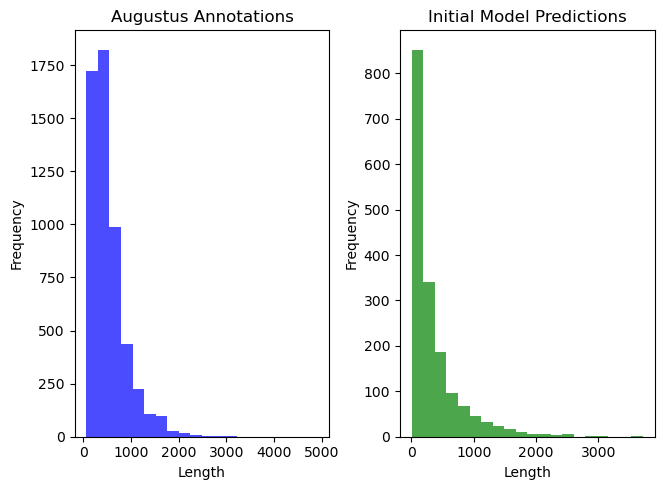

In [6]:
# Counting Stop codons
n_StopCodons_initial_model = check_for_stop_codon(proteins_initial_model)

print(f"The initial model has predicted: {n_StopCodons_initial_model} Stop Codons as coding ")

# Getting widths of sequences
width_augustus = [len(seq) for seq in proteins_agustus]
width_initial_model = [len(seq) for seq in proteins_initial_model]
#width_trained_model = [len(seq) for seq in proteins_trained_model]

# Plotting histograms
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(width_augustus, bins=20, color='blue', alpha=0.7)
plt.title('Augustus Annotations')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(width_initial_model, bins=20, color='green', alpha=0.7)
plt.title('Initial Model Predictions')
plt.xlabel('Length')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

### Training model

Now that we have initialized our model and created our training data we are ready to start training the model. We do that by caling the function `model.fit(training_data, training_data_lengths)` this will train the model using the viterbi algorithm. 

Notes: 

1. We train our model on training data.
2. We can set the number of iterations to train for by changing the `n_iter` parameter when initialising the model. 
3. In this example we have wraped the training expression  in `time.time()` to get the running time for the training. 

In [7]:

start_time = time.time()

# Training the model using Viterbi training
gene_annot_model.fit(X_training, lengths_training)

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")


Execution time: 24.378747701644897 seconds


### Saving model and loading model

We dont have this as part of this homework but it could be convinent for you to save parameter values once models are trained (it can take a long time to train models). Maybe you would like to return to a model for further testing or you are supper happy with it and wants to save it to use it later. You can read up on saving and loading basic data object in Python on [saving data](https://hmmlearn.readthedocs.io/en/latest/tutorial.html)

### Annotate chromosome

Once the model is trained we can use the trained model to annotate our test chromosome with `C` or `N` (coding or non-coding nucleobase). We do this with the function `HMM_model.predict(observations)`, below we annotate the test set both using the initial model and the model that we trained. 

After annotating we can gather the indices for the predicted coding regions of the test data. With the indices of the coding region and the DNA sequence we can translate the regions in to their respective proteins with the helper function `convert_to_proteins(indices, observations)`.

In [8]:


PATTERN = "C+"  # Simple pattern getting the annotation You might want to try "N+" as well as the model does not know the difference between C and N

# Using Viterbi algorithm to predict annotations with initial model
annotation_trained_model_int = gene_annot_model.predict(X_test, lengths_test)
annotation_trained_model_char = [ id2region[_id] for _id in annotation_trained_model_int] 

# Getting start and stop indices of annotations for initial model
annotation_indices_trained_model = get_gene_start_and_stop_from_annotation(annotation_trained_model_char, PATTERN)

# Converting annotations to proteins for initial model
proteins_trained_model = convert_to_proteins(annotation_indices_trained_model, test_observations_string)




/opt/conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


The initial model has predicted: 32604 Stop Codons as coding 
The trained model has predicted: 27430 Stop Codons as coding 


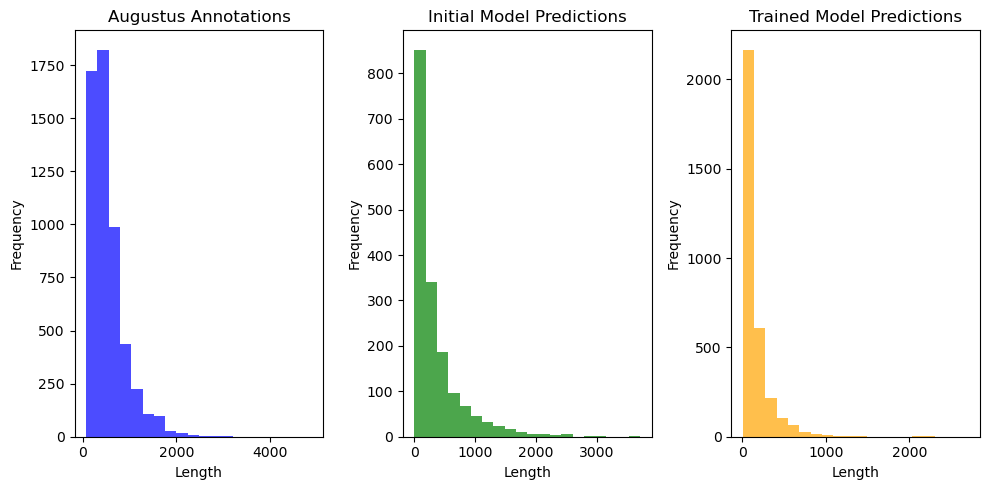

In [9]:
n_StopCodons_trained_model = check_for_stop_codon(proteins_trained_model)

print(f"The initial model has predicted: {n_StopCodons_initial_model} Stop Codons as coding ")
print(f"The trained model has predicted: {n_StopCodons_trained_model} Stop Codons as coding ")

# Getting widths of sequences
width_augustus = [len(seq) for seq in proteins_agustus]
width_initial_model = [len(seq) for seq in proteins_initial_model]
width_trained_model = [len(seq) for seq in proteins_trained_model]

# Plotting histograms
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(width_augustus, bins=20, color='blue', alpha=0.7)
plt.title('Augustus Annotations')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(width_initial_model, bins=20, color='green', alpha=0.7)
plt.title('Initial Model Predictions')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(width_trained_model, bins=20, color='orange', alpha=0.7)
plt.title('Trained Model Predictions')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Some caveats

1: The Augustus distribution is from the whole genome not just the training set, if you want to you can save the specific chromosomes that you have in your test set in a separate .fasta file and re run augustus on that to only extract the proteins corresponding to chromosomes in your test set. In a real world scenario that would be the way to do it. However we don't expect to much differences in the length distribution between chromosomes.  

2: There are other methods for measuring the performance of your model, you could for example download the proteome from a data base like NCBI instead of using Augustus. You could also compare the proteins predicted by your model and the reference proteome using MSA to see the differences, for our purposes that is over kill. 

3: Here we used a simple model with only two states coding and non-coding however DNA, as you know, have many more distinct regions with different roles. most often in machine learning picking the right model architecture that best describes the data is an art and well worth spending some time on.

4: When we initiated our models parameters we already knew roughly what they should be based on our knowledge of biology. However, it is not always the case that we have such prior knowledge, in those cases we usually start from a uniform distribution of the parameters.

5: When translating our predicted genes you can see that some places is annotated with * rather then a character of an amino acid these residues indicate instead that a stop codon was translated. 

6: The function provided for you to extract gene positions requires a regular expression (pattern) that describes what a gene looks like given the hidden states you chose ("C+" here). If you have trouble adjusting it for your model, get in touch with us since regexes were not covered in the course. If you want to experiment, https://regex101.com/ is a great size that tests and analyzes regexes

# 4. Assignment: Build a better HMM

Your turn! Create a better HMM using the example and code provided and try your best to get better results.
How well can you do against Augustus? :) (the important thing is to build + use the model so don't worry about matching it - just aim to improve results)


Remember to Have fun!

### Model DEFINES

In [24]:
# Define the hidden states of your HMM model
states = ["C", "I", "N"] # Coding: C; Intron: I; Intergenic: N

# Conversion dictionary states (char to int)
id2region = dict(zip(range(len(states)), states))

vocabulary = ["A", "C", "G", "T"]
# Convert "sentences" to numbers:
vocab2id = dict(zip(vocabulary, range(len(vocabulary))))
id2vocab = {value: key for key, value in vocab2id.items()}

### Initiate HMM model

In [25]:
# Model Parameters
start_probs = np.array([0.3, 0.6, 0.1]) # Coding (0.3), Intron; Intergenic (0.7)
emission_probs = np.array([[0.24, 0.26, 0.27], 
                           [0.27, 0.22, 0.23],
                           [0.28, 0.22, 0.23],
                           [0.21, 0.30, 0.27]]).T
trans_mat = np.array([[0.990, 0.007, 0.003],  # Coding; Intron; Intergenic
                      [0.010, 0.990, 0.000],
                      [0.001, 0.000, 0.999]])


# Initiating a simple HMM model
gene_annot_model = hmm.CategoricalHMM(n_components=3, n_iter=50, init_params='')

 #Set the initial parameters
gene_annot_model.startprob_ = start_probs  # Initial probabilities for each state
gene_annot_model.transmat_ = trans_mat  # Transition probabilities between states                       
gene_annot_model.emissionprob_ = emission_probs  # Emission probabilities for each symbol in each state
                                  

### Evaluate initial model

In [26]:
PATTERN = "C+(I*C+)*"  # Pattern for recognizing at least one C, with optional I between them

# Using Viterbi algorithm to predict annotations with initial model
annotation_initial_model_int = gene_annot_model.predict(X_test, lengths_test)
annotation_initial_model_char = [ id2region[_id] for _id in annotation_initial_model_int] 

# Getting start and stop indices of annotations for initial model
annotation_indices_initial_model = get_gene_start_and_stop_from_annotation(annotation_initial_model_char, PATTERN)
# Getting start and stop indices of annotations for trained model

# Converting annotations to proteins for initial model
proteins_initial_model = convert_to_proteins(annotation_indices_initial_model, test_observations_string)

/opt/conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


The initial model has predicted: 881 Stop Codons as coding 


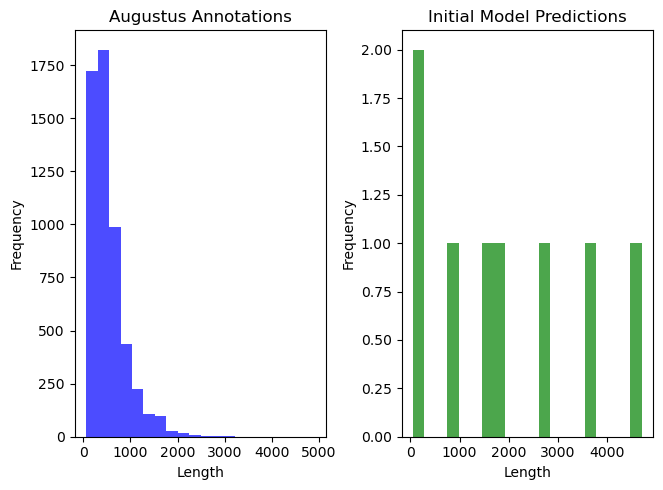

In [27]:
# Counting Stop codons
n_StopCodons_initial_model = check_for_stop_codon(proteins_initial_model)

print(f"The initial model has predicted: {n_StopCodons_initial_model} Stop Codons as coding ")

# Getting widths of sequences
width_augustus = [len(seq) for seq in proteins_agustus]
width_initial_model = [len(seq) for seq in proteins_initial_model]
#width_trained_model = [len(seq) for seq in proteins_trained_model]

# Plotting histograms
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(width_augustus, bins=20, color='blue', alpha=0.7)
plt.title('Augustus Annotations')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(width_initial_model, bins=20, color='green', alpha=0.7)
plt.title('Initial Model Predictions')
plt.xlabel('Length')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

### Training model

In [28]:

start_time = time.time()

# Training the model using Viterbi training
gene_annot_model.fit(X_training, lengths_training)

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")


Execution time: 35.230438470840454 seconds


### Annotate chromosome

In [29]:


PATTERN = "C+(I*C+)*"  # Pattern for recognizing at least one C, with optional I between them

# Using Viterbi algorithm to predict annotations with initial model
annotation_trained_model_int = gene_annot_model.predict(X_test, lengths_test)
annotation_trained_model_char = [ id2region[_id] for _id in annotation_trained_model_int] 

# Getting start and stop indices of annotations for initial model
annotation_indices_trained_model = get_gene_start_and_stop_from_annotation(annotation_trained_model_char, PATTERN)

# Converting annotations to proteins for initial model
proteins_trained_model = convert_to_proteins(annotation_indices_trained_model, test_observations_string)




/opt/conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


The initial model has predicted: 881 Stop Codons as coding 
The trained model has predicted: 5579 Stop Codons as coding 


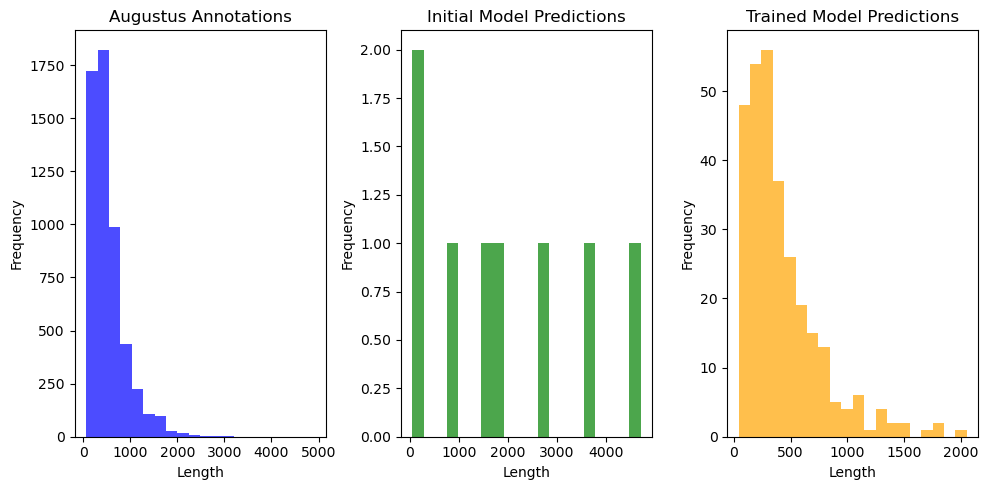

In [30]:
n_StopCodons_trained_model = check_for_stop_codon(proteins_trained_model)

print(f"The initial model has predicted: {n_StopCodons_initial_model} Stop Codons as coding ")
print(f"The trained model has predicted: {n_StopCodons_trained_model} Stop Codons as coding ")

# Getting widths of sequences
width_augustus = [len(seq) for seq in proteins_agustus]
width_initial_model = [len(seq) for seq in proteins_initial_model]
width_trained_model = [len(seq) for seq in proteins_trained_model]

# Plotting histograms
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(width_augustus, bins=20, color='blue', alpha=0.7)
plt.title('Augustus Annotations')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(width_initial_model, bins=20, color='green', alpha=0.7)
plt.title('Initial Model Predictions')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(width_trained_model, bins=20, color='orange', alpha=0.7)
plt.title('Trained Model Predictions')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**To complete this homework you need to:**

1. Initiate your own HMM model (DO NOT USE THE SIMPLE 2 STATE EXAMPLE!!!)
    * Explain the architecture of your model states emmissions etc.
    * Explain what initial parameters you chose and why.
    * Explain if you use any of the references provided or you found your own.
    * Explain if you did test different model architectures or different initial parameters (Not a requirement that you do)
2. Train your model on data
    * Explain what data you used as training data and why (what chromosomes)
    * Explain what training algorithm you used, did you test both?
    * Explain how many training iterations did you use and why that number.
3. Evaluate your model with augustus results as shown in the example code.
    * Explain what data you used as testing data (should not be the same as training data).
    * Show at least three histograms with the augustus results initial model and trained model
    * Discuss shortly the evaluation, did your model improve with training, did you get close to augustus?
4. Given unlimited resorces in both compute and time would you have liked test something more? (just a few sentences)
